# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [51]:
import artm

In [52]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [53]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [54]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="target_folder", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [55]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1},
                      num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [56]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [57]:
def printTop():
    for topic_name in model_artm.topic_names:
        print topic_name + ': ',
        tokens = model_artm.score_tracker["top_words"].last_tokens
        for word in tokens[topic_name]:    
            print word,
        print

In [58]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_authors", num_tokens=15, class_id="author"))

In [59]:
model_artm.initialize("dictionary")

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [60]:
# Ваш код
tau = 1e5
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau, dictionary=dictionary, 
                                                            class_ids={'text':1}, topic_names="bcg"))



Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [61]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

In [62]:
printTop()

sbj0:  частица быть что это этот который взаимодействие кварк теория весь как физика симметрия такой они
sbj1:  быть это этот материал что который как мочь такой для структура температура при свойство очень
sbj2:  быть что это политический который этот как государство власть тот такой очень для все царь
sbj3:  что этот это быть который язык как система один или такой университет мочь если тот
sbj4:  что быть это который этот человек мозг они как ребенок такой если мочь слово очень
sbj5:  быть что этот который это как они миф человек весь время такой век она бог
sbj6:  быть это что этот который как город они русский человек очень такой текст для говорить
sbj7:  они это что который человек этот быть как очень другой мочь или самый трудность для
sbj8:  право что быть этот это как который такой римский вещь мочь тот правовой если юрист
sbj9:  это быть который что этот как или боль мочь человек они очень когда для наука
sbj10:  это быть что этот который они как робот год для такой очень моч

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [63]:
# Ваш код
tau2 = -1e5
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', 
                                                            tau=tau2, dictionary=dictionary, 
                                                            class_ids={'text':1}, topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [64]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [65]:
# Ваш код
printTop()

sbj0:  частица взаимодействие физика кварк стандартный симметрия дмитрий элементарный нейтрино материя протон масса слабый фундаментальный построить
sbj1:  материал структура температура свойство вещество химический соединение поверхность давление химия применение электронный углерод металл сверхпроводимость
sbj2:  политический государство политика власть царь партия положение труд правитель кризис враг ритуал средневековый сага борьба
sbj3:  университет объяснять школа объект предмет образование естественный познание логика восприятие студент факультет воспринимать учитель аргумент
sbj4:  слово мозг ребенок категория мышление лицо нейрон предложение конструкция значение корпус позиция контекст взрослый чтение
sbj5:  бог миф греческий герой существо след древний мифология роман грек странный сущность предок персонаж мифологический
sbj6:  русский текст город написать городской перевод сохраняться москва локальный гласный документ немецкий говор письмо пьеса
sbj7:  трудность раса праздни

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [115]:
sbj_topic_labels = [u'Физика элементарных частиц',
                    u'Химия материалов',
                   u'История',
                   u'Педагогика',
                   u'Нейронаука',
                   u'Античная литература',
                   u'Лингвистика',
                   u'Акультизм',
                   u'Юриспруденция',
                   u'Валиология',
                   u'Эволюционная биология',
                   u'Психология',
                   u'Первая мировая война',
                   u'Наука',
                   u'Астономия',
                   u'Микроэкономика',
                   u'Психология семьи',
                   u'Программирование',
                   u'Культура востока',
                   u'Генетика',
                   u'Квантовая физика',
                   u'Литература',
                   u'История реформаций',
                   u'СССР',
                   u'Религия',
                   u'Математика',
                   u'Театр',
                   u'Звезды',
                   u'Режисура']   # запишите названия тем в список
topic_labels = sbj_topic_labels + [u'Фоновая тема']

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [188]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids={'author':1})
theta = model_artm.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

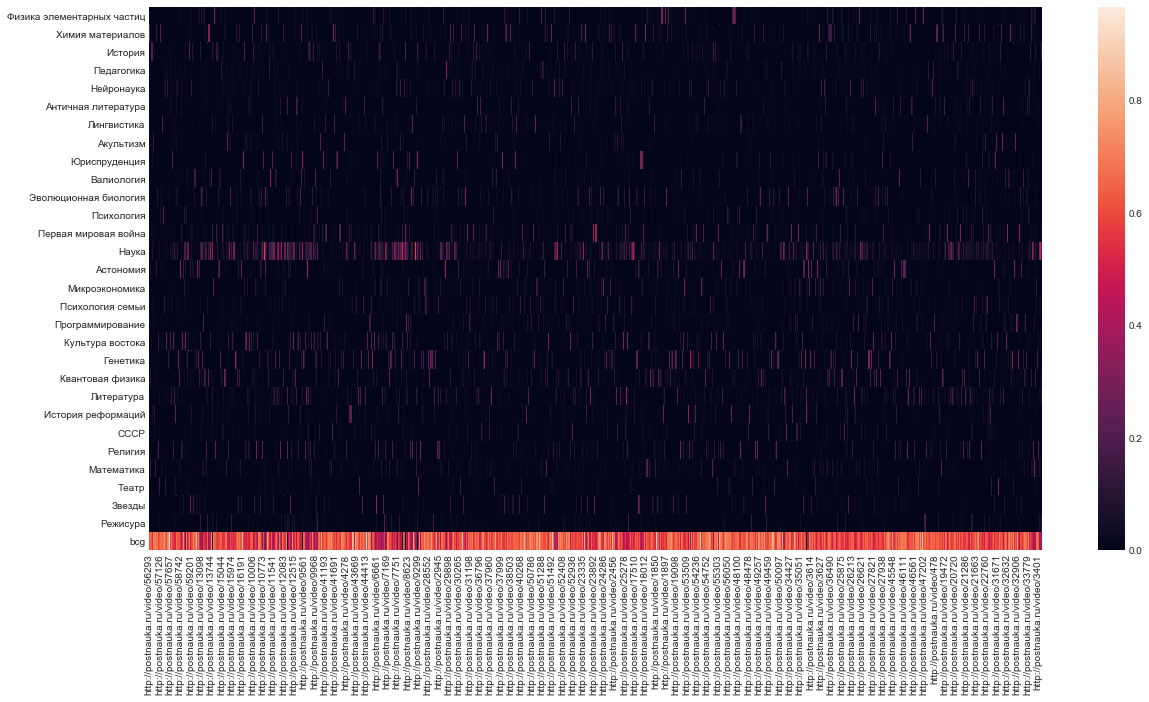

In [147]:
# Ваш код
plt.figure(figsize = (20, 10))
theta = theta.rename({"sbj"+str(i):topic_labels[i] for i in range(29)})

seaborn.heatmap(data=theta.head(100))

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [189]:
# Ваш код
dt = pd.DataFrame()
dt["p(t)"] = theta.sum(axis=1)
dt["p(t)"] = dt["p(t)"]/dt["p(t)"].sum()
dt

,p(t)
sbj0,0.012474
sbj1,0.017456
sbj2,0.012020
sbj3,0.009385
sbj4,0.011483
sbj5,0.008314
sbj6,0.009570
sbj7,0.006454
sbj8,0.009189
sbj9,0.008616


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [190]:
dt.sort_values(by=["p(t)"], ascending=False)[2:7]


,p(t)
sbj19,0.023841
sbj21,0.019473
sbj20,0.018863
sbj12,0.018371
sbj14,0.017636


In [191]:
dt.sort_values(by=["p(t)"], ascending=True)[:3]

,p(t)
sbj26,0.004685
sbj7,0.006454
sbj11,0.006826


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

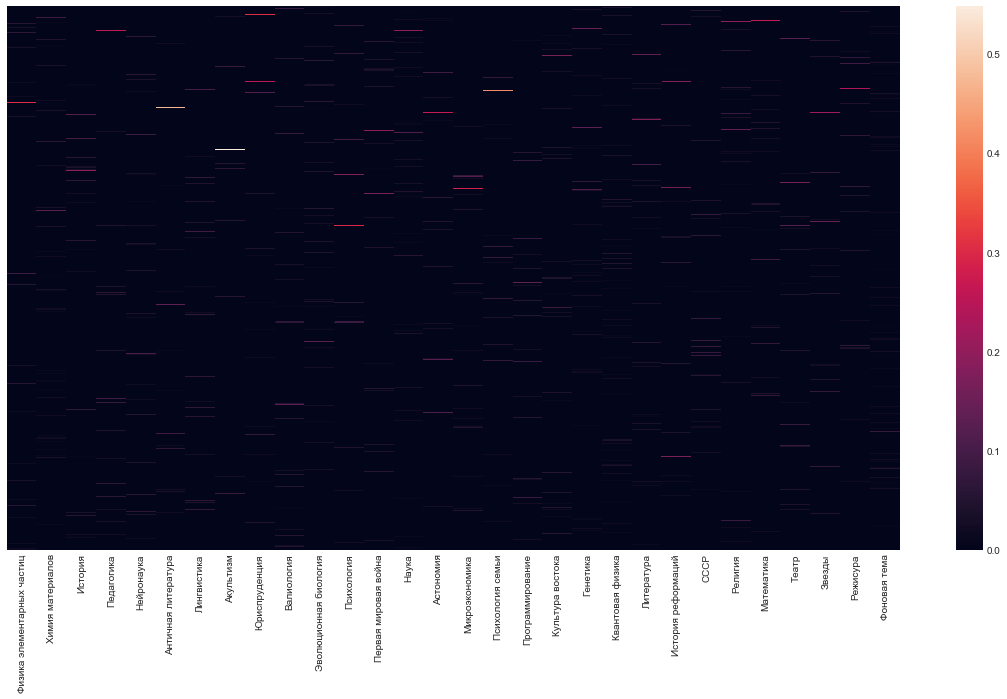

In [192]:
# Ваш код
plt.figure(figsize = (20, 10))
phi_a.columns = topic_labels
seaborn.heatmap(data=phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [193]:
dp=phi_a.copy()
dp[dp <= 0.01] = 0
dp[dp > 0.01] = 1
dp['pat']=dp.sum(axis=1)
dp[dp['pat']>=3]['pat']

Александр_Филиппов       3.0
Фёдор_Успенский          3.0
Михаил_Алексеевский      4.0
Мария_Фаликман           4.0
Николай_Дронин           3.0
Илья_Иткин               4.0
Олег_Ауров               3.0
Анатолий_Баранов         3.0
Константин_Мирошников    3.0
Александр_Тормасов       3.0
Ян_Левченко              4.0
Андрей_Чабовский         3.0
Павел_Нерлер_(Полян)     3.0
Ольга_Вайнштейн          4.0
Андрей_Журавлев          3.0
Александр_Пиперски       4.0
Name: pat, dtype: float32

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [194]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [200]:
# Ваш код
dpat=phi_a.transpose()
dpta=dpat.copy()
dpta.loc[:,:]=0
dpta.index=topic_labels
dpat.index=topic_labels
dpt=pd.DataFrame(dt['p(t)'].copy())
#Удаление фоновой темы
dpat=dpat[:29]
dpta=dpta[:29]
dpt=dpt[:29]

pat_pt=pd.DataFrame(dpat.as_matrix()*dpt.as_matrix(),columns=dpat.columns,index=dpat.index)
pta=pd.DataFrame(pat_pt.as_matrix()/pat_pt.sum().as_matrix().reshape(1,-1),columns=dpat.columns,index=dpat.index)


tt=MDS(random_state=42,dissimilarity="precomputed")
data_mds=pairwise_distances(pta.fillna(0).transpose(),metric="cosine")
MDS_transformed_cos=tt.fit_transform(data_mds)


C:\Users\KONYAYEV.MAKSIM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


Визуализируйте найденные двумерные представления с помощью функции scatter. 

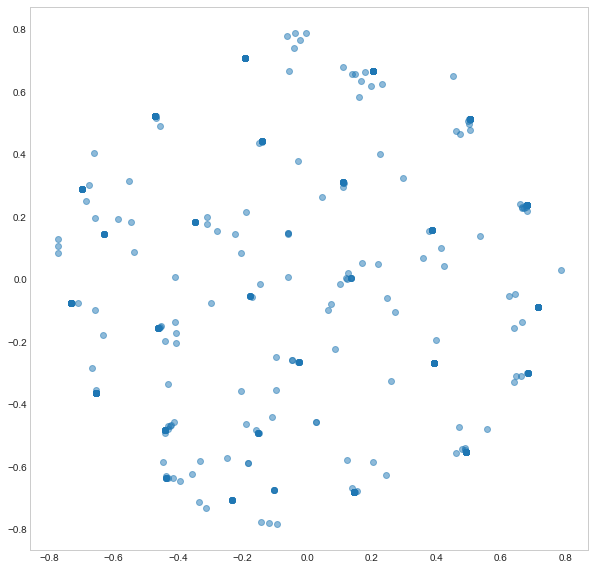

In [203]:
# Ваш код
plt.subplots(figsize=(10,10))
plt.scatter(MDS_transformed_cos[:,0],  
                MDS_transformed_cos[:,1], alpha=0.5,)
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

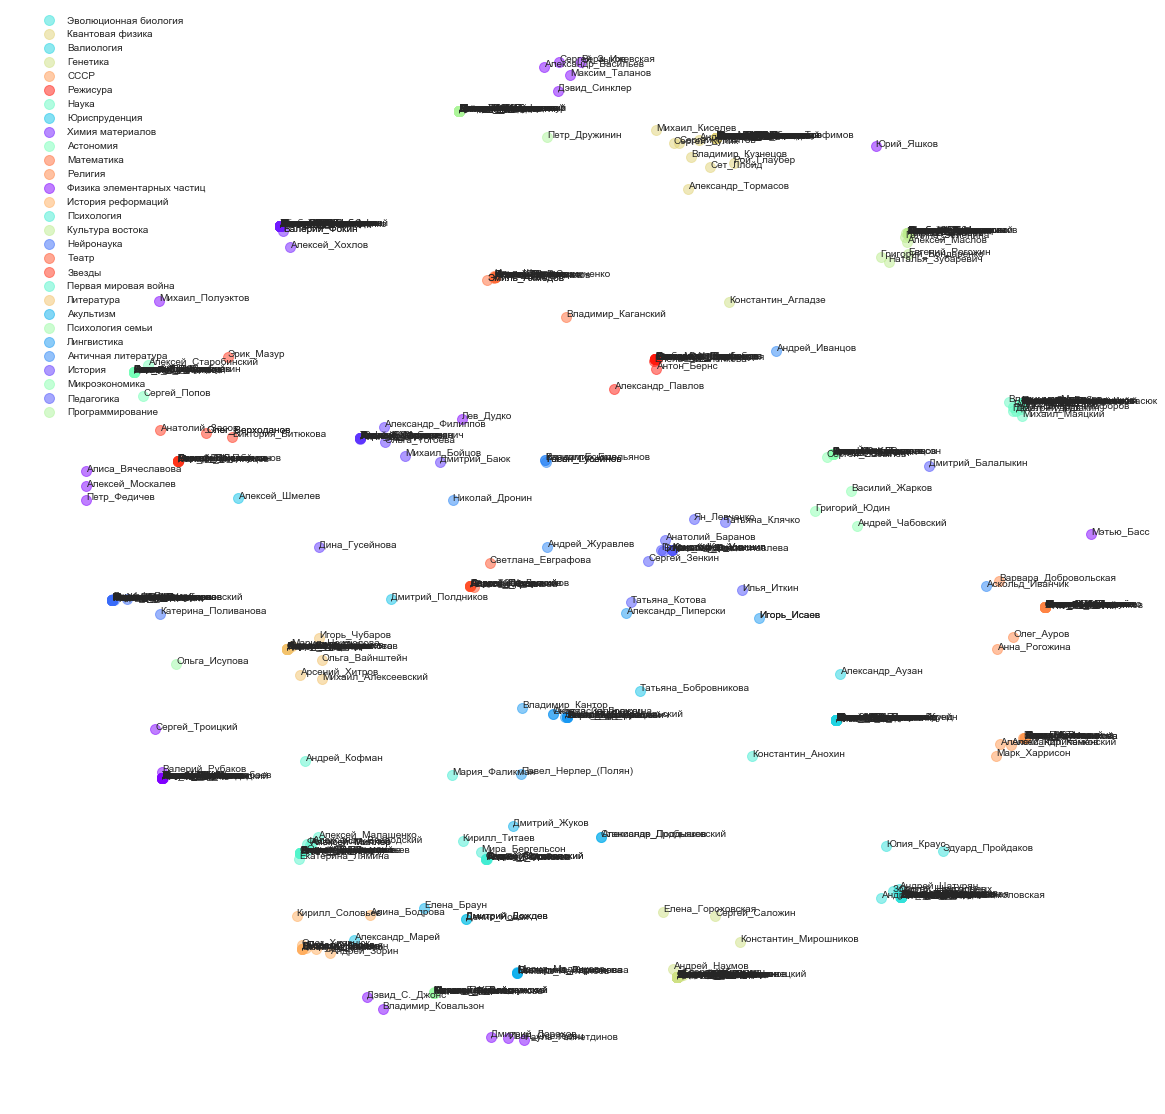

In [206]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
fig = plt.figure(figsize=(20, 20))
    
label_flag = [True]*T
max_t = [pta.transpose().as_matrix()[i].argmax() for i in range(len(pta.columns))]
d={}
for i, dot in enumerate(MDS_transformed_cos):
    if label_flag[max_t[i]]:
        plt.scatter(dot[0], dot[1], c=colors[max_t[i]], alpha=0.5, s=100, label=topic_labels[max_t[i]])
        label_flag[max_t[i]] = False
        plt.annotate(pta.transpose().index[i], (dot[0], dot[1]))
    else:
        plt.scatter(dot[0], dot[1], c=colors[max_t[i]], alpha=0.5, s=100)
    plt.annotate(pta.transpose().index[i], (dot[0], dot[1]))

plt.legend(loc='upper left')
plt.axis("off") 

plt.savefig("amap.pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [207]:
# Ваш код
dpdt= pd.DataFrame(theta.as_matrix() / theta.sum(axis=1).as_matrix().reshape(-1,1),columns=theta.columns, index=topic_labels)[:29]
dpdt[:5]

,http://postnauka.ru/video/56293,http://postnauka.ru/video/56295,http://postnauka.ru/video/56297,http://postnauka.ru/video/56300,http://postnauka.ru/video/56302,http://postnauka.ru/video/56304,http://postnauka.ru/video/56306,http://postnauka.ru/video/5633,http://postnauka.ru/video/56616,http://postnauka.ru/video/56618,...,http://postnauka.ru/video/3391,http://postnauka.ru/video/33941,http://postnauka.ru/video/3401,http://postnauka.ru/video/3402,http://postnauka.ru/video/3403,http://postnauka.ru/video/3404,http://postnauka.ru/video/3405,http://postnauka.ru/video/3406,http://postnauka.ru/video/3417,http://postnauka.ru/video/3418
Физика элементарных частиц,3.688185e-04,3.964304e-04,4.250013e-04,3.612319e-04,1.375650e-16,2.613790e-07,4.865168e-04,0.000233,0.000185,7.994255e-07,...,2.821781e-16,0.000000,2.434617e-04,0.000808,1.944663e-07,0.000000,0.000065,0.000000,0.0,0.000000e+00
Химия материалов,7.828210e-03,8.607655e-03,2.454687e-04,1.255738e-04,1.813217e-05,2.967196e-05,9.538547e-05,0.000000,0.000578,8.491428e-12,...,0.000000e+00,0.000000,4.762216e-04,0.000270,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00
История,5.926181e-10,0.000000e+00,1.985556e-12,0.000000e+00,1.048552e-04,9.870796e-03,0.000000e+00,0.009891,0.000048,2.136709e-04,...,2.486502e-04,0.001251,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,7.294733e-03
Педагогика,3.043360e-05,8.292116e-08,1.870574e-04,2.214710e-03,5.043899e-04,8.154127e-05,4.204198e-04,0.000000,0.001483,3.335061e-04,...,7.128245e-04,0.000756,1.293388e-14,0.000614,0.000000e+00,0.000000,0.002284,0.000000,0.0,5.756697e-15
Нейронаука,1.037271e-05,1.653105e-08,4.487670e-05,1.513498e-08,6.724732e-04,5.473281e-05,1.835229e-09,0.000000,0.010362,3.073099e-04,...,3.481099e-04,0.000824,2.320713e-04,0.000395,0.000000e+00,0.004374,0.000000,0.002141,0.0,0.000000e+00


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [208]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [209]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [216]:
# Ваш код
for i in range(T):
    display(HTML(u"<h2>{}</h2>".format(topic_labels[i])))
    display(HTML(u"<h3>Видео</h3>"))
    for i, ref  in enumerate(dpdt.iloc[i].sort_values(ascending=False)[:10].index):
        display(HTML(u'<li><a href="{}">Видео {}</a></li>'.format(ref, i+1)))

IndexError: single positional indexer is out-of-bounds

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 